In [1]:
#Loading necessary libraries for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = 'WeeklyInfectionDiseaseData.csv'
data = pd.read_csv(file_path)

# Create Year column, standardize and trim column names
data['Year'] = data['Epidemiology Wk'].str.split('-').str[0]
data.columns = data.columns.str.strip().str.title()

# Looking at data loaded
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 58 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Epidemiology Wk                     660 non-null    object
 1   Start                               660 non-null    object
 2   End                                 660 non-null    object
 3   Cholera                             660 non-null    int64 
 4   Paratyphoid                         660 non-null    int64 
 5   Typhoid                             660 non-null    int64 
 6   Acute Viral Hepatitis A             660 non-null    int64 
 7   Acute Viral Hepatitis E             660 non-null    int64 
 8   Poliomyelitis                       660 non-null    int64 
 9   Plague                              660 non-null    int64 
 10  Yellow Fever                        660 non-null    int64 
 11  Dengue                              660 non-null    int64 

,Epidemiology Wk,Start,End,Cholera,Paratyphoid,Typhoid,Acute Viral Hepatitis A,Acute Viral Hepatitis E,Poliomyelitis,Plague,...,Campylobacterenterosis,Zika Virus Infection,Campylobacter Enterosis,"Hand, Foot And Mouth Disease",Campylobacteriosis,Monkeypox,Salmonellosis (Non-Enteric Fevers),Mpox,Middle East Respiratory Syndrome,Year
0,2012-01,01/01/2012,07/01/2012,0,1,6,0,0,0,0,...,0,0,0,326,6,0,0,0,0,2012
1,2012-02,08/01/2012,14/01/2012,0,1,3,0,0,0,0,...,0,0,0,346,7,0,0,0,0,2012
2,2012-03,15/01/2012,21/01/2012,0,1,5,0,0,0,0,...,0,0,0,463,9,0,0,0,0,2012
3,2012-04,22/01/2012,28/01/2012,0,1,1,0,0,0,0,...,0,0,0,372,8,0,0,0,0,2012
4,2012-05,29/01/2012,04/02/2012,0,3,5,0,0,0,0,...,0,0,0,444,8,0,0,0,0,2012


In [2]:
# Pick up the columns of importance
important_columns = data[['Epidemiology Wk','Start','End','Year']]

# Drop the columns of importance to only have disease names columns remaining
df_rest = data.drop(columns=['Epidemiology Wk','Start','End','Year'])

# Create a dictionary to map columns with similar names
# Mapping columns that represent the same disease
rename_dict = {
    'Viral Hepatitis A': 'Acute Viral Hepatitis A',
    'Viral Hepatitis E': 'Acute Viral Hepatitis E',
    'Dhf': 'Dengue',
    'Dengue Fever': 'Dengue',
    'Dengue Haemorrhagic Fever': 'Dengue',
    'Chikungunya Fever': 'Chikungunya',
    'Hfmd': 'HFMD',
    'Hand, Foot Mouth Disease': 'HFMD',
    'Hand, Foot And Mouth Disease': 'HFMD',
    'Sars': 'SARS',
    'Nipah Virus Infection': 'Nipah',
    'Campylobacterenterosis': 'Campylobacter Enteritis',
    'Campylobacter Enterosis': 'Campylobacter Enteritis',
    'Campylobacteriosis': 'Campylobacter Enteritis',
    'Salmonellosis (Non-Enteric Fevers)': 'Salmonellosis(Non-Enteric Fevers)',
    'Zika Virus Infection': 'Zika',
    'Mpox': 'Monkeypox',
# Add more mappings as necessary
}

# Apply renaming
df_rest = df_rest.rename(columns=rename_dict)

# Combine the counts of similar columns by grouping and summing them so that there is only 1 unique ccolumn of each disease left
df_rest = df_rest.groupby(df_rest.columns, axis=1).sum()

# Return the columns of importance back into the dataset
final_df = pd.concat([important_columns, df_rest], axis=1)

# Looking at the final data
final_df.info()
final_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Epidemiology Wk                    660 non-null    object
 1   Start                              660 non-null    object
 2   End                                660 non-null    object
 3   Year                               660 non-null    object
 4   Acute Viral Hepatitis A            660 non-null    int64 
 5   Acute Viral Hepatitis B            660 non-null    int64 
 6   Acute Viral Hepatitis C            660 non-null    int64 
 7   Acute Viral Hepatitis E            660 non-null    int64 
 8   Avian Influenza                    660 non-null    int64 
 9   Botulism                           660 non-null    int64 
 10  Campylobacter Enteritis            660 non-null    int64 
 11  Chikungunya                        660 non-null    int64 
 12  Cholera 

C:\Users\ryuse\AppData\Local\Temp\ipykernel_84012\2438319056.py:34: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_rest = df_rest.groupby(df_rest.columns, axis=1).sum()


,Epidemiology Wk,Start,End,Year,Acute Viral Hepatitis A,Acute Viral Hepatitis B,Acute Viral Hepatitis C,Acute Viral Hepatitis E,Avian Influenza,Botulism,...,Plague,Pneumococcal Disease (Invasive),Poliomyelitis,Rubella,SARS,Salmonellosis(Non-Enteric Fevers),Tetanus,Typhoid,Yellow Fever,Zika
0,2012-01,01/01/2012,07/01/2012,2012,1,0,0,3,0,0,...,0,3,0,1,0,26,0,6,0,0
1,2012-02,08/01/2012,14/01/2012,2012,2,0,0,0,0,0,...,0,3,0,2,0,24,0,3,0,0
2,2012-03,15/01/2012,21/01/2012,2012,3,0,0,0,0,0,...,0,3,0,4,0,21,0,5,0,0
3,2012-04,22/01/2012,28/01/2012,2012,3,1,0,2,0,0,...,0,2,0,2,0,12,0,1,0,0
4,2012-05,29/01/2012,04/02/2012,2012,2,1,0,0,0,0,...,0,5,0,0,0,37,0,5,0,0


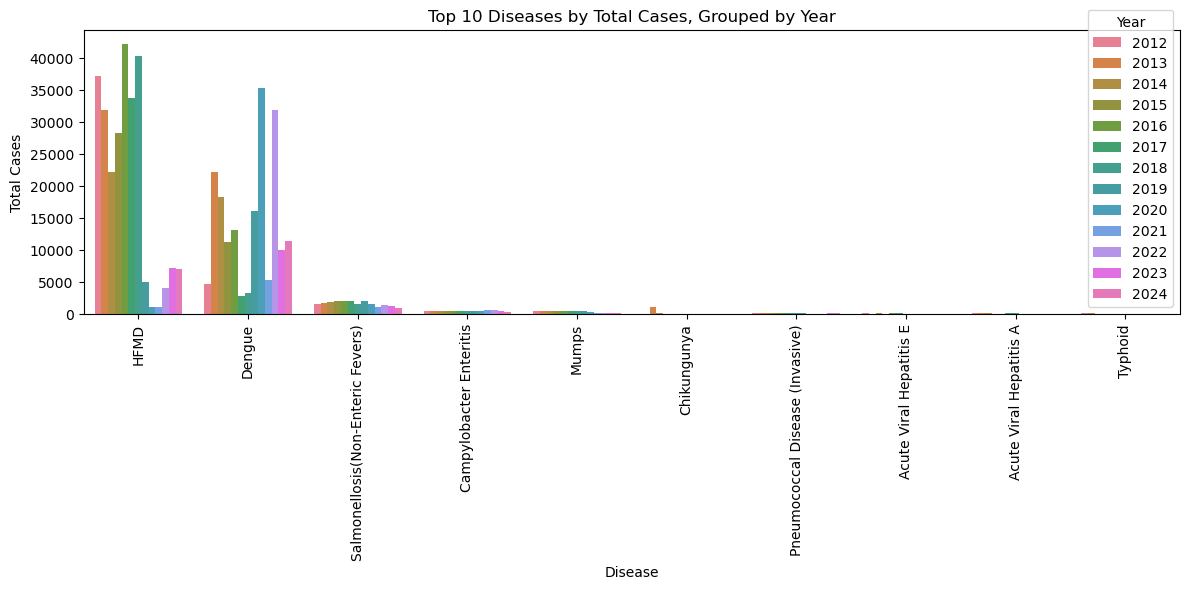

In [3]:
# Visualising the top 10 disease by total cases, grouped by year
# Feature Engineering: Create a total cases column by summing all diseases
disease_columns = final_df.columns[4:]  # All disease columns start from the 5th column

# Calculate the total number of cases for each disease across all years
total_cases = final_df[disease_columns].sum().sort_values(ascending=False)

# Get the top 10 diseases by total count
top_10_diseases = total_cases.head(10).index

# Filter the dataset to include only the top 10 diseases
yearly_totals = final_df.groupby('Year')[top_10_diseases].sum().reset_index()

# Reshape the dataset for plotting
yearly_totals_melted = yearly_totals.melt(id_vars='Year', var_name='Disease', value_name='Total Cases')

# Plot the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Disease', y='Total Cases', hue='Year', data=yearly_totals_melted)

# Rotate the x labels for better readability
plt.xticks(rotation=90)
plt.title('Top 10 Diseases by Total Cases, Grouped by Year')
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
# Preparing for Classification via Random Forest Classifier
# Total the number of cases per disease into a column
final_df['Total_Cases'] = final_df[disease_columns].sum(axis=1)

# Labeling weeks as "High" (1) or "Normal" (0) based on a threshold
# Assuming top 10% weeks are considered 'High Outbreak'
threshold = np.percentile(final_df['Total_Cases'], 90)
final_df['Outbreak_Label'] = np.where(final_df['Total_Cases'] >= threshold, 1, 0)

# Define features (X) and labels (y)
X = final_df[disease_columns]  # Disease cases as features
y = final_df['Outbreak_Label']  # Binary classification target

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(rf_clf.feature_importances_, index=disease_columns)
print("Feature Importance:\n", feature_importances.sort_values(ascending=False))

Accuracy: 0.9545454545454546
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       177
           1       1.00      0.57      0.73        21

    accuracy                           0.95       198
   macro avg       0.98      0.79      0.85       198
weighted avg       0.96      0.95      0.95       198

Feature Importance:
 Dengue                               0.257435
HFMD                                 0.245868
Chikungunya                          0.073803
Salmonellosis(Non-Enteric Fevers)    0.054960
Mumps                                0.037008
Campylobacter Enteritis              0.035588
Pneumococcal Disease (Invasive)      0.025914
Measles                              0.025905
Acute Viral Hepatitis E              0.024461
Typhoid                              0.021822
Acute Viral Hepatitis B              0.019623
Rubella                              0.019346
Pertussis                            0.019310
M


### **Model Performance:**
1. **Accuracy: 95.45%**
   - The model correctly classified the outbreak and non-outbreak weeks in about 95% of the cases. This is a good overall performance, but accuracy can sometimes be misleading if the classes are imbalanced, so we need to check more detailed metrics.

2. **Classification Report:**
   - **Class 0 (Normal Weeks):**
     - **Precision (0.95):** Out of all weeks classified as normal, 95% were actually normal.
     - **Recall (1.00):** The model correctly identified all the actual normal weeks.
     - **F1-Score (0.98):** High precision and recall result in a very strong F1 score for normal weeks.
   
   - **Class 1 (High Outbreak Weeks):**
     - **Precision (1.00):** The model was perfect in identifying high-outbreak weeks, meaning when it said there was an outbreak, it was always right.
     - **Recall (0.57):** However, it only identified 57% of all actual high-outbreak weeks, meaning it's missing a significant number of outbreaks.
     - **F1-Score (0.73):** This shows the model struggles with recall on outbreaks, but overall the balance of precision and recall is decent.

   - **Macro Average:** The average performance across both classes, showing the model is more heavily skewed towards identifying normal weeks rather than outbreaks, due to imbalanced class sizes.
   
   - **Weighted Average:** The performance is weighted according to the class distribution (since most weeks are normal). The weighted average is similar to the overall accuracy, at around 95%.

### **Class Imbalance:**
- There is an imbalance between the number of normal weeks (177) and high-outbreak weeks (21). This class imbalance impacts the model’s ability to detect high-outbreak weeks, as evidenced by the relatively lower recall (0.57) for outbreaks.

### **Feature Importance:**
- **Top Features:** 
   - **Dengue (25.74%) and HFMD (24.59%)** are the most important features in predicting whether a week is a high-outbreak week. This suggests that these diseases contribute significantly to determining outbreak weeks.
   - **Chikungunya (7.38%)** and **Salmonellosis (5.49%)** are also important but to a lesser extent.

- **Low/Zero-Importance Features:**
   - Several diseases, such as **Plague, SARS, Poliomyelitis, Yellow Fever**, and others, have no impact on the model's predictions. This could be because there are very few or no recorded cases for these diseases in the dataset.

### **Key Insights:**
1. **Model Strength:** The model performs well in detecting normal weeks but has lower recall for high-outbreak weeks. You might want to address this imbalance through techniques like **SMOTE (Synthetic Minority Over-sampling)**, or by adjusting **class weights** to improve recall for outbreaks.
   
2. **Most Important Diseases:** Dengue and HFMD are the leading indicators of high-outbreak weeks. Focusing on monitoring and predicting these two diseases might provide significant insights for public health decision-making.

3. **Class Imbalance Issue:** The model struggles to detect high-outbreak weeks due to the imbalance between normal and outbreak weeks. Techniques to handle class imbalance, such as oversampling or undersampling,  the model's performance on outbreak de

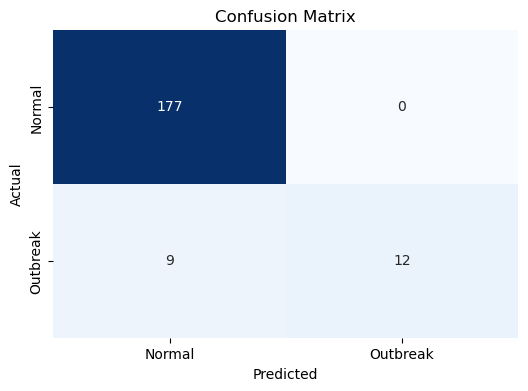

C:\Users\ryuse\AppData\Local\Temp\ipykernel_84012\1918583801.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='viridis')


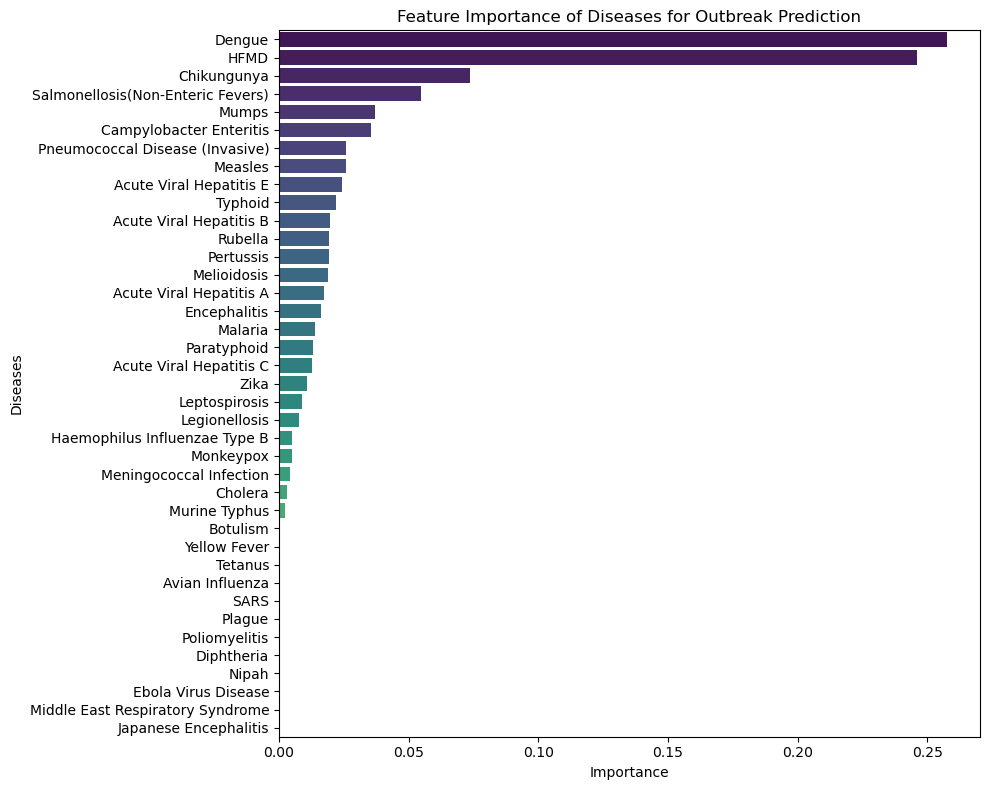

In [5]:
# 1. Confusion Matrix Visualization
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Outbreak'], yticklabels=['Normal', 'Outbreak'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Feature Importance Bar Chart
# Sort feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10,8))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='viridis')
plt.title('Feature Importance of Diseases for Outbreak Prediction')
plt.xlabel('Importance')
plt.ylabel('Diseases')
plt.tight_layout()
plt.show()

In [6]:
# 1. Handling Class Imbalance: SMOTE for Oversampling the Minority Class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/Test Split with resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 2. Class Weight Adjustment in Random Forest
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_clf.fit(X_train_res, y_train_res)

# Predictions
y_pred_res = rf_clf.predict(X_test_res)

# Evaluation
print("Accuracy:", accuracy_score(y_test_res, y_pred_res))
print("Classification Report:\n", classification_report(y_test_res, y_pred_res))

Accuracy: 0.9859943977591037
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       191
           1       0.98      0.99      0.99       166

    accuracy                           0.99       357
   macro avg       0.99      0.99      0.99       357
weighted avg       0.99      0.99      0.99       357



In [7]:
# 3. Hyperparameter Tuning with Grid Search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Best Parameters and Model Performance
best_rf_clf = grid_search.best_estimator_
y_pred_best = best_rf_clf.predict(X_test_res)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [8]:
# Final Evaluation
print("Best Random Forest Parameters:", grid_search.best_params_)
print("Best Model Accuracy:", accuracy_score(y_test_res, y_pred_best))
print("Best Model Classification Report:\n", classification_report(y_test_res, y_pred_best))

Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Model Accuracy: 0.9859943977591037
Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       191
           1       0.98      0.99      0.98       166

    accuracy                           0.99       357
   macro avg       0.99      0.99      0.99       357
weighted avg       0.99      0.99      0.99       357



The new output shows a significant improvement in model performance after addressing class imbalance, adjusting class weights, applying SMOTE, and tuning hyperparameters.

### **1. Accuracy: 98.60%**
- The model correctly classified approximately 98.60% of both normal and high-outbreak weeks.
- This is a strong indication that the model is performing exceptionally well overall, but it's important to dive deeper into other metrics, especially when working with imbalanced data.

### **2. Classification Report Breakdown**
- **Class 0 (Normal Weeks):**
  - **Precision (0.99):** Out of all weeks predicted as normal, 99% were actually normal.
  - **Recall (0.98):** The model correctly identified 98% of the actual normal weeks.
  - **F1-Score (0.99):** A balance between precision and recall, indicating excellent performance for normal weeks.

- **Class 1 (High-Outbreak Weeks):**
  - **Precision (0.98):** Out of all weeks predicted as high-outbreak weeks, 98% were correct.
  - **Recall (0.99):** The model detected 99% of all actual high-outbreak weeks, meaning it can now reliably identify outbreaks.
  - **F1-Score (0.99):** Similar to class 0, this shows that the model is very balanced in terms of predicting high-outbreak weeks.

- **Macro Average:**
  - Both precision and recall average at **0.99**, meaning the model performs well for both classes, which suggests that the model is no longer biased toward one class (as it was before).
  
- **Weighted Average:**
  - Since the dataset is still slightly imbalanced, the weighted average provides a performance summary across both classes. With an F1-score of **0.99**, the model excels overall.

### **3. Grid Search Best Parameters**
- The grid search found the best hyperparameters for the Random Forest model:
  - **`n_estimators=200`**: The model uses 200 trees, which balances computation time with accuracy.
  - **`max_depth=20`**: Trees are allowed to grow to a depth of 20, which controls model complexity and prevents overfitting.
  - **`min_samples_split=5` and `min_samples_leaf=1`**: These parameters ensure that splits and leaf nodes have enough data, improving generalization.

### **What You Can Read from the Output:**
- **Balanced Performance**: After applying SMOTE and class weight adjustments, the model now has near-equal performance across both normal and high-outbreak weeks. Both precision and recall are excellent for both classes, showing that the model is no longer biased toward the majority class.
  
- **Highly Predictive Features**: The diseases used in the feature importance plot (visualized) will show which diseases contribute most to the prediction of outbreak weeks. Diseases with higher feature importance (like **Dengue** and **HFMD**) are likely the key drivers of outbreaks in the dataset.

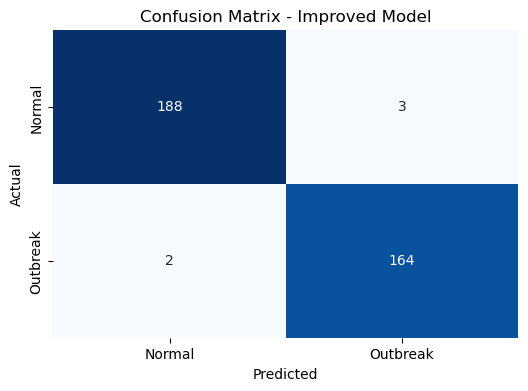

C:\Users\ryuse\AppData\Local\Temp\ipykernel_84012\705113783.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='viridis')


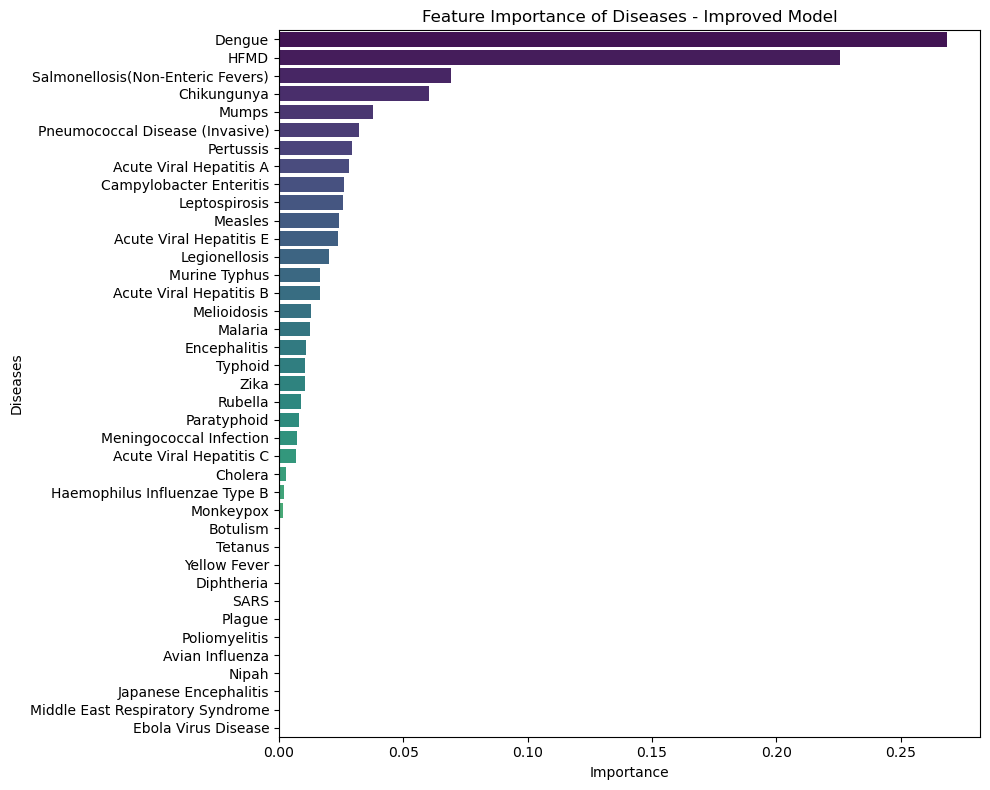

In [9]:
# 1. Confusion Matrix Visualization
# Calculate confusion matrix
cm = confusion_matrix(y_test_res, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Outbreak'], yticklabels=['Normal', 'Outbreak'])
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. Feature Importance Bar Chart
# Retrieve the best model's feature importances
best_feature_importances = pd.Series(best_rf_clf.feature_importances_, index=disease_columns)

# Sort feature importances in descending order
sorted_importances = best_feature_importances.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10,8))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index, palette='viridis')
plt.title('Feature Importance of Diseases - Improved Model')
plt.xlabel('Importance')
plt.ylabel('Diseases')
plt.tight_layout()
plt.show()